# Comparing models

This notebook organizes variables conditioned on binned values of some other variable. Here we use `omega500` to define dynamical regimes, and look at the conditional averages of cloud-related quantities.

This notebook makes:
- Figure 7 of the manuscript: SWCRE($\omega_{500}$).
- Figure 8: cltcalipso($z$, $\omega_{500}$)
- Figure 9: EMD($\omega_{500}$)

This notebook is messy.

The original version didn't use `intake-esm`, and I tried to do a conversion.

Clean up.
- need to define some functions to avoid repeating code
- Organize I/O section into a few cells that make sense.


(12 January 2023) 
- Use `comp.rm_land()` instead of defining a version here. Drop in replace.
- There's a fair amount of code duplicated here and in `combined_histogram_error_by_omega_plot.ipynb`. I'm going to try to use that as a way to get some of this code cleaned up, and make the line plot consistent with that version.

(23-24 February)
- I'm trying to use plotting_methods to make these plots consistent with the EMD histogram error version in `combined_histogram_error_by_omega_plot.ipynb`
- This consolidation around `plot_lines_by_omega` works, and add the "twin" axis for Fig 7 to show the PDF of omega500 works well. 
- There is duplicated code between there and here for the binning; that *should* go into `computations.py`
    - moved `binned_mean` to `computations.py` as general clean up. 
    - `weigted_binned` was repeated twice here and nearly duplicated in `combined_histogram_error_by_omega_plot.ipynb`, so I moved it to `computations`

In [6]:
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from pathlib import Path
import ast
import intake
import intake_esm
from intake_esm import DerivedVariableRegistry

# loc = Path("/Volumes/Samsung_T5/cosp2021") 

import colorcet as cc
cmap = cc.cm.glasbey_category10
# cmap = cc.cm.glasbey_dark

import scipy.stats as ss
import computations as comp
import mod_io as mio
import plotting_methods as plm  # Regions, plot_lines_by_omega

import cmasher as cmr

# import regionmask # used to make landmask on arbitrary grid

import string # string.ascii_uppercase 


In [7]:
import importlib
def reloader(nameOfModule):
    importlib.reload(nameOfModule)

# Run this cell to reload custom modules.
reloader(mio)
reloader(comp)
reloader(plm)

In [8]:
#
# intake-esm seems unable to do a derived variable for a dataset that has multiple variables
# That's problematic for CERES and getting SWCF or LWCF
# Workaround is to drop the derived variables for OBS for now,
# and essentially do it manually. 


## Preliminaries

Define parameters and conenience functions.

In [9]:
remove_land = True
#
# IDENTIFY VARIABLES NEEDED HERE
#
variables_to_load = ['OMEGA500','cltcalipso', 'SWCF', 'clcalipso'] # ['SWCF', 'LWCF', 'OMEGA500', 'rlut', 'rlutcs']  # ["clcalipso", "OMEGA500"]
variables_to_plot = ["cltcalipso", "SWCF", "clcalipso"]  # subset of variables_to_load
# SWCF => Fig 7
# clcalipso =>  Fig 8
# cltcalipso => Fig 9

# Aux. data:
land = xr.load_dataset("/Users/brianpm/Dropbox/Data/cesm2_f09_land.nc")['LANDFRAC'].squeeze()

if remove_land:
    rmlandstr = "noland"
else:
    rmlandstr = "withland"


# define colors for line plots
# colorkey = {"CAM4": cc.cm.glasbey_cool(0),
#            "CAM5": cc.cm.glasbey_cool(1),
#            "CAM6": cc.cm.glasbey_cool(2),
#            "E3SM": cc.cm.glasbey_cool(3),
#            "OBS": "gray",
#            "CALIPSO": "gray",
#            "CERES": "gray"}
colorkey = {"CAM4": "#56B4E9",
           "CAM5": "#0072B2",
           "CAM6": "#E69F00",
           "E3SM": "#D55E00",
           "OBS": "#999999",
           "CALIPSO": "#999999",
           "CERES": "#999999"}

# Sets binning for each possible dynamic variable:
# LTS & EIS aren't used, but could be added for future analysis.
xbins = {"OMEGA500" : np.arange(-100, 110, 10),
         "LTS" : np.arange(0.5, 31.5, 1),
         "EIS" : np.arange(-5.5, 12.5, 0.5)}

xlabel_string = {"OMEGA500" : "$\omega_{500}$ [hPa d$^{-1}$]",
                 "LTS" : "LTS [K]",
                 "EIS" : "EIS [K]"}

xvariable = "OMEGA500"  # PARAMETERS to determine variable to use for binning.

#
# Parameters to define the regions
#
regions = {"global":plm.Regions('global', slice(-60,60), "Global Ocean"),
          "tropics":plm.Regions('tropics', slice(-30,30), "Tropical Ocean"),
          "socean":plm.Regions('socean', slice(-60,-30), "Southern Ocean")}  # try -45 instead of -30
# Use regions[region].region_definition() to get string for latitude band.
# Replaces "region key" dict

# Test sensitivity of global being -60-60 vs -90-60 ... I'm going to demark those in file names with a "g60"

#
# Parameters related to output figures
#
clobber_fig = False # if file already exists, overwrite?


## I/O Section

In [10]:
# Catalogs & Derived Variable Registries
rootdir = Path("/Volumes/Drudonna/")
catsfils = {
    "CAM4": rootdir / "cam4_1deg_release_amip" / "catalog" / "catalog_cam4_1deg_release_amip.json",
    "CAM5": rootdir / "cam5_1deg_release_amip" / "catalog" / "catalog_cam5_1deg_release_amip.json",
    "CAM6": rootdir / "f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1" / "catalog" / "catalog_f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1.json",
    "E3SM": rootdir / "E3SM-1-0_amip" / "catalog" / "catalog_E3SM-1-0_amip.json",
    "OBS" : rootdir / "catalog_satellite_clouds_monthly.json"
}

# also define the derived variable registry:
dvr_objs = {"CAM4":DerivedVariableRegistry.load("CAM_derived_variable_registry"),
           "CAM5":DerivedVariableRegistry.load("CAM_derived_variable_registry"),
           "CAM6":DerivedVariableRegistry.load("CAM_derived_variable_registry"),
           "E3SM":DerivedVariableRegistry.load("e3sm_derived_variable_registry"),
           "OBS":None}
csv_kw = {"CAM4":None, "CAM5":None, "CAM6":None, "E3SM":None, "OBS":{"converters": {"variable": ast.literal_eval}}}

cats = {c: intake.open_esm_datastore(str(catsfils[c]), registry=dvr_objs[c], read_csv_kwargs=csv_kw[c]) for c in catsfils}

cats_subset = {}
for c in cats:
    if c == 'E3SM':
        cats_subset[c] = cats[c].search(variable=variables_to_load, member_id="r1i1p1f1")
    else:
        try:
            cats_subset[c] =  cats[c].search(variable=variables_to_load)
        except Exception:
            print(f"Sorry -- search failed for {c}")
#
# Loading the datasets
#
dsets = {}
for c in cats_subset:
    dcod = True if c == "OBS" else False
    tmp = cats_subset[c].to_dataset_dict(xarray_open_kwargs={"decode_times": dcod})
    if len(tmp.keys()) == 1:
        if c == 'OBS':
            dsets[list(tmp.keys())[0]] = tmp[list(tmp.keys())[0]]
        else:
            dsets[c] = tmp[list(tmp.keys())[0]] # call it CAM/E3SM
    elif c == 'E3SM':
        dsets[c] = xr.merge(tmp.values())
    else:
        dsets = {**dsets, **tmp} # adds ISCCP/MISR/MODIS as keys

timeslice = slice("2000-01-01","2020-12-31")

for dsn in dsets:
    if 'time_bnds' in dsets[dsn]:
        bnddim = [d != 'time' for d in dsets[dsn].time_bnds.dims].index(True)
        tmptime = dsets[dsn]['time_bnds'].mean(dim=dsets[dsn].time_bnds.dims[bnddim])
        tmptime.attrs = dsets[dsn]['time'].attrs
        dsets[dsn] = dsets[dsn].assign_coords({"time":tmptime})
        dsets[dsn] = xr.decode_cf(dsets[dsn])
    else:
        print(f"Did not find `time_bnds` in dataset {dsn}")

dsets = {c: dsets[c].sel(time=timeslice).load() for c in dsets}


Did not find `time_bnds` in dataset CALIPSO


In [11]:
# Manually enter CERES data
if ("SWCF" in variables_to_load) and ("CERES" not in dsets):
     print("derive SWCF")
     ceres_ds = xr.open_mfdataset(cats['OBS'].df[cats['OBS'].df['source'] == 'CERES']['path'].values)
     sw, lw = ceres_ds['toa_cre_sw_mon'].sel(time=timeslice).load(), ceres_ds['toa_cre_lw_mon'].sel(time=timeslice).load()
     sw.name = 'SWCF'
     lw.name = 'LWCF'
     dsets['CERES'] = xr.Dataset({'SWCF':sw, 'LWCF':lw})

derive SWCF


In [12]:
# -- Add ERA5 omega500 to observation data --
epath = "/Volumes/Drudonna/ERA5/remapped/era5_monthly_w500_1979-2020_unpack.nc" # put onto CAM grid same way as other data & dims renamed
with xr.open_dataset(epath) as eds:
    ew5 = eds['w']*864. 
    ew5.attrs['units'] = 'hPa d**-1'
    ew5.name = "OMEGA500"
    for src in set(cats['OBS'].df['source']):
        if src in dsets:
            select_times = dsets[src]["time"].dt.strftime("%Y-%m")
            ew5_srctime = ew5.sel(time=select_times) 
            assert np.all(ew5_srctime.lat == dsets[src]['lat']), "Lat mismatch"
            assert np.all(ew5_srctime.lon == dsets[src]['lon']), "Lon mismatch"
            ew5_srctime = ew5_srctime.assign_coords({'time':dsets[src]["time"]})
            dsets[src]['OMEGA500'] = ew5_srctime
        else:
            print(f"{src} is not in dsets, so will not add ERA5 OMEGA500 to it.")


MISR is not in dsets, so will not add ERA5 OMEGA500 to it.
MODIS is not in dsets, so will not add ERA5 OMEGA500 to it.
ISCCP is not in dsets, so will not add ERA5 OMEGA500 to it.


In [13]:
# At this point, I want to make sure that OMEGA500 is in hPa/day and clcalipso is in PERCENT for all datasets
for d in dsets:
    if 'clcalipso' in dsets[d]:
        if dsets[d]['clcalipso'].max() < 2:
            dsets[d]['clcalipso'] *= 100.0
            dsets[d]['clcalipso'].attrs['units'] = 'percent'
            print(f"Adjusted clcalipso for {d}")
    if 'cltcalipso' in dsets[d]:
        if dsets[d]['cltcalipso'].max() < 2:
            dsets[d]['cltcalipso'] *= 100.0
            dsets[d]['cltcalipso'].attrs['units'] = 'percent'
            print(f"Adjusted cltcalipso for {d}")        
    if 'OMEGA500' in dsets[d]:
        if dsets[d]['OMEGA500'].max() < 10:
            print(f"inferring that OMEGA500 is in Pa/s ---> units says: {dsets[d]['OMEGA500'].attrs['units']}")
            if 'hPa' not in dsets[d]['OMEGA500'].attrs['units']:
                print("double checked and `hPa` not in units, so will transform")
                dsets[d]['OMEGA500'] *= 864.0
                dsets[d]['OMEGA500'].attrs['units'] = 'hPa d**-1'


inferring that OMEGA500 is in Pa/s ---> units says: Pa/s
double checked and `hPa` not in units, so will transform
inferring that OMEGA500 is in Pa/s ---> units says: Pa/s
double checked and `hPa` not in units, so will transform
inferring that OMEGA500 is in Pa/s ---> units says: Pa/s
double checked and `hPa` not in units, so will transform
inferring that OMEGA500 is in Pa/s ---> units says: Pa s-1
double checked and `hPa` not in units, so will transform
Adjusted clcalipso for CALIPSO
Adjusted cltcalipso for CALIPSO


In [14]:
## ALSO, for some reason altitude is the dimension name in CALIPSO, but not a coordinate variable, so fix that here
if "CALIPSO" in dsets:
    if 'altitude' not in dsets["CALIPSO"].coords:
        with xr.open_dataset("/Volumes/Drudonna/CALIPSO/GOCCP/3Ddata/remapped/fv09/3D_CloudFraction330m_200606_avg_CFMIP2_sat_3.1.2.nc") as exfile:
            dsets["CALIPSO"] = dsets["CALIPSO"].assign_coords({'altitude':exfile['alt_mid']})
        

## Some Notes

Right now we have the complication that OMEGA500 (and LTS and EIS) is calculated and saved separately from my previous code. Using that is easier than waiting around to calculate it.

A couple of cells down, put all the needed variables into a dictionary called `cat`. 

The model land mask is just called `land` and is taken from a separate file that I've got in Dropbox.

After the models are loaded, we deal with observations/ERA5. Those are regridded and combined into a Dataset, and that Dataset is added to `cat`. 

The point is that we have one big data structure, `cat`, that can be used to get all the original data.

From there, we will create dictionaries that hold the binned statistics by region. 

**UPDATE**
When I added E3SM to the mix of models, I also built intake-esm catalogs, so switching this notebook to use those. 

The E3SM catalog points at the files regridded to the FV09 grid, allowing use of same land mask. I did, however, have to re-do the remapping to make sure that all the variables are correctly using the `nco` algorithm. 

I also needed to update the Observations catalog to include `clcalipso` (including remapping and fixing scalar time issue for 3D files).


**ADDENDUM**
I also realized that `OMEGA500` for the CAM runs was derived by me, and I wrote the "correct" time coordinate. That breaks when I switch to catalogs because the time coordinate does not match the other variables. 

I updated the script `save_omega_500.py` and re-ran it to save `OMEGA500` with the same time as the other variables.


**CAUTION**
Watch the units on `OMEGA500` and make sure they are consistent across data. Otherwise the binned statistics won't work. 

## Analysis Section
- remove land if requested
- bin `variables_to_plot` by OMEGA500 -> creates a `binned` dict

In [15]:
# NOTE: irreversible change (need to reload to make a different choice)
if remove_land:
    for d in dsets:
        for v in dsets[d].data_vars:
            dsets[d][v] = comp.rm_land(dsets[d][v], land)


[rm_land] Latitudes mismatch. Largest discrepancy is 1.4210854715202004e-14 degrees.
[rm_land] Latitudes mismatch. Largest discrepancy is 1.4210854715202004e-14 degrees.
[rm_land] Latitudes mismatch. Largest discrepancy is 1.4210854715202004e-14 degrees.
[rm_land] Latitudes mismatch. Largest discrepancy is 1.4210854715202004e-14 degrees.
[rm_land] Latitudes mismatch. Largest discrepancy is 1.4210854715202004e-14 degrees.
[rm_land] Latitudes mismatch. Largest discrepancy is 1.4210854715202004e-14 degrees.
[rm_land] Latitudes mismatch. Largest discrepancy is 1.4210854715202004e-14 degrees.
[rm_land] Latitudes mismatch. Largest discrepancy is 1.4210854715202004e-14 degrees.
[rm_land] Latitudes mismatch. Largest discrepancy is 1.4210854715202004e-14 degrees.
[rm_land] Latitudes mismatch. Largest discrepancy is 1.4210854715202004e-14 degrees.
[rm_land] Latitudes mismatch. Largest discrepancy is 1.4210854715202004e-14 degrees.
[rm_land] Latitudes mismatch. Largest discrepancy is 1.4210854715

In [16]:
# get conditional average

binned = dict()          # binned -> region -> model/obs -> Dataset of binned variables
xhistograms = dict()     # xhistograms -> region -> model/obs -> OMEGA500 histogram
        # tmp = np.zeros(clcalipso_binned_shape)
        # for k in range(len(clcalipso.altitude)):
        #     y_bs, edg, num = ss.binned_statistic(x.values.flatten(), y.isel(altitude=k).values.flatten(), statistic=np.nanmean, bins=xbins[xvariable])
        #     tmp[:,k] = y_bs
        # tmp = xr.DataArray(tmp, dims=["bins","altitude"], coords={"bins":bctr, "altitude":clcalipso['altitude']})
        # clcalipso_binned[region][mdl] = tmp

# constructed bins include under and over:
bin_ctr = xbins[xvariable][0:-1] + 0.5*np.diff(xbins[xvariable])
bin_ctr = np.insert(bin_ctr, 0, xbins[xvariable][0] - 0.5*(xbins[xvariable][1]-xbins[xvariable][0]))
bin_ctr = np.append(bin_ctr, xbins[xvariable][-1] + 0.5*(xbins[xvariable][-1]-xbins[xvariable][-2]))
# for consistency in the bins, use updated bin edges for histogram


for region in regions:
    print(f"{region =}")
    binned[region] = dict()
    xhistograms[region] = dict()
    for name in dsets:
        if xvariable not in dsets[name]:
            print(f"Did not find {xvariable} in {name}, skipping.")
            continue
        x = dsets[name][xvariable].sel(lat=regions[region].latitudes, time=timeslice)
        hbins = xbins[xvariable]
        hbins = np.insert(hbins, 0, np.finfo(float).min)
        hbins = np.append(hbins, np.finfo(float).max)
        xhistograms[region][name], _ = np.histogram(x.values.flatten(), bins=hbins, density=True)
        xhistograms[region][name] = xhistograms[region][name] * np.diff(_)  # converts to probability mass function (sum = 1.0)
        result = []
        for variable in variables_to_plot:
            if variable not in dsets[name]:
                print(f"Did not find {variable} in {name}, skipping.")
                continue
            print(f"{region = }, {name = }, {variable = }")
            assert variable in dsets[name], f'Variable: {variable} not in dsets[{name}]'
            y = dsets[name][variable].sel(lat=regions[region].latitudes, time=timeslice)
            if y.shape == x.shape:
                # y_bs, edg, num = weighted_binned(x, y, xbins[xvariable])
                # bin_ctr = edg[0:-1] + 0.5*np.diff(edg)
                y_bs = comp.binned_mean(x, y, xbins[xvariable])
                yxr = xr.DataArray(y_bs, dims=f'{xvariable}_bin_center', coords={f'{xvariable}_bin_center':bin_ctr}, name=variable)
                result.append(yxr)
            else:
                if len(y.shape) == (len(x.shape)+1):
                    zdim = set(y.dims).difference(x.dims).pop()
                    zcoord = y[zdim] # hack to get the name of the height dimension
                    y_bs = comp.binned_mean(x, y, xbins[xvariable])
                    # the bins that come back include a beginning bin for anything (-inf, xbins[xvariable][0])
                    yxr = xr.DataArray(y_bs, dims=[f'{xvariable}_bin_center', zdim], coords={f'{xvariable}_bin_center':bin_ctr, zdim:zcoord}, name=variable)
                    result.append(yxr)
        binned[region][name] = xr.merge(result, compat='identical')

region ='global'


/Users/brianpm/opt/miniconda3/envs/pyten/lib/python3.10/site-packages/numpy/lib/function_base.py:5394: RuntimeWarning: invalid value encountered in cast
  values = array(values, copy=False, ndmin=arr.ndim, dtype=arr.dtype)


region = 'global', name = 'CAM4', variable = 'cltcalipso'
region = 'global', name = 'CAM4', variable = 'SWCF'
region = 'global', name = 'CAM4', variable = 'clcalipso'


/Users/brianpm/opt/miniconda3/envs/pyten/lib/python3.10/site-packages/numpy/lib/function_base.py:5394: RuntimeWarning: invalid value encountered in cast
  values = array(values, copy=False, ndmin=arr.ndim, dtype=arr.dtype)


region = 'global', name = 'CAM5', variable = 'cltcalipso'
region = 'global', name = 'CAM5', variable = 'SWCF'
region = 'global', name = 'CAM5', variable = 'clcalipso'


/Users/brianpm/opt/miniconda3/envs/pyten/lib/python3.10/site-packages/numpy/lib/function_base.py:5394: RuntimeWarning: invalid value encountered in cast
  values = array(values, copy=False, ndmin=arr.ndim, dtype=arr.dtype)


region = 'global', name = 'CAM6', variable = 'cltcalipso'
region = 'global', name = 'CAM6', variable = 'SWCF'
region = 'global', name = 'CAM6', variable = 'clcalipso'


/Users/brianpm/opt/miniconda3/envs/pyten/lib/python3.10/site-packages/numpy/lib/function_base.py:5394: RuntimeWarning: invalid value encountered in cast
  values = array(values, copy=False, ndmin=arr.ndim, dtype=arr.dtype)


region = 'global', name = 'E3SM', variable = 'cltcalipso'
region = 'global', name = 'E3SM', variable = 'SWCF'
region = 'global', name = 'E3SM', variable = 'clcalipso'


/Users/brianpm/opt/miniconda3/envs/pyten/lib/python3.10/site-packages/numpy/lib/function_base.py:5394: RuntimeWarning: invalid value encountered in cast
  values = array(values, copy=False, ndmin=arr.ndim, dtype=arr.dtype)


region = 'global', name = 'CALIPSO', variable = 'cltcalipso'
Did not find SWCF in CALIPSO, skipping.
region = 'global', name = 'CALIPSO', variable = 'clcalipso'


/Users/brianpm/opt/miniconda3/envs/pyten/lib/python3.10/site-packages/numpy/lib/function_base.py:5394: RuntimeWarning: invalid value encountered in cast
  values = array(values, copy=False, ndmin=arr.ndim, dtype=arr.dtype)


Did not find cltcalipso in CERES, skipping.
region = 'global', name = 'CERES', variable = 'SWCF'
Did not find clcalipso in CERES, skipping.
region ='tropics'
region = 'tropics', name = 'CAM4', variable = 'cltcalipso'
region = 'tropics', name = 'CAM4', variable = 'SWCF'


/Users/brianpm/opt/miniconda3/envs/pyten/lib/python3.10/site-packages/numpy/lib/function_base.py:5394: RuntimeWarning: invalid value encountered in cast
  values = array(values, copy=False, ndmin=arr.ndim, dtype=arr.dtype)


region = 'tropics', name = 'CAM4', variable = 'clcalipso'


/Users/brianpm/opt/miniconda3/envs/pyten/lib/python3.10/site-packages/numpy/lib/function_base.py:5394: RuntimeWarning: invalid value encountered in cast
  values = array(values, copy=False, ndmin=arr.ndim, dtype=arr.dtype)


region = 'tropics', name = 'CAM5', variable = 'cltcalipso'
region = 'tropics', name = 'CAM5', variable = 'SWCF'
region = 'tropics', name = 'CAM5', variable = 'clcalipso'


/Users/brianpm/opt/miniconda3/envs/pyten/lib/python3.10/site-packages/numpy/lib/function_base.py:5394: RuntimeWarning: invalid value encountered in cast
  values = array(values, copy=False, ndmin=arr.ndim, dtype=arr.dtype)


region = 'tropics', name = 'CAM6', variable = 'cltcalipso'
region = 'tropics', name = 'CAM6', variable = 'SWCF'
region = 'tropics', name = 'CAM6', variable = 'clcalipso'


/Users/brianpm/opt/miniconda3/envs/pyten/lib/python3.10/site-packages/numpy/lib/function_base.py:5394: RuntimeWarning: invalid value encountered in cast
  values = array(values, copy=False, ndmin=arr.ndim, dtype=arr.dtype)


region = 'tropics', name = 'E3SM', variable = 'cltcalipso'
region = 'tropics', name = 'E3SM', variable = 'SWCF'
region = 'tropics', name = 'E3SM', variable = 'clcalipso'


/Users/brianpm/opt/miniconda3/envs/pyten/lib/python3.10/site-packages/numpy/lib/function_base.py:5394: RuntimeWarning: invalid value encountered in cast
  values = array(values, copy=False, ndmin=arr.ndim, dtype=arr.dtype)


region = 'tropics', name = 'CALIPSO', variable = 'cltcalipso'
Did not find SWCF in CALIPSO, skipping.
region = 'tropics', name = 'CALIPSO', variable = 'clcalipso'


/Users/brianpm/opt/miniconda3/envs/pyten/lib/python3.10/site-packages/numpy/lib/function_base.py:5394: RuntimeWarning: invalid value encountered in cast
  values = array(values, copy=False, ndmin=arr.ndim, dtype=arr.dtype)


Did not find cltcalipso in CERES, skipping.
region = 'tropics', name = 'CERES', variable = 'SWCF'
Did not find clcalipso in CERES, skipping.
region ='socean'


/Users/brianpm/opt/miniconda3/envs/pyten/lib/python3.10/site-packages/numpy/lib/function_base.py:5394: RuntimeWarning: invalid value encountered in cast
  values = array(values, copy=False, ndmin=arr.ndim, dtype=arr.dtype)


region = 'socean', name = 'CAM4', variable = 'cltcalipso'
region = 'socean', name = 'CAM4', variable = 'SWCF'
region = 'socean', name = 'CAM4', variable = 'clcalipso'


/Users/brianpm/opt/miniconda3/envs/pyten/lib/python3.10/site-packages/numpy/lib/function_base.py:5394: RuntimeWarning: invalid value encountered in cast
  values = array(values, copy=False, ndmin=arr.ndim, dtype=arr.dtype)


region = 'socean', name = 'CAM5', variable = 'cltcalipso'
region = 'socean', name = 'CAM5', variable = 'SWCF'
region = 'socean', name = 'CAM5', variable = 'clcalipso'


/Users/brianpm/opt/miniconda3/envs/pyten/lib/python3.10/site-packages/numpy/lib/function_base.py:5394: RuntimeWarning: invalid value encountered in cast
  values = array(values, copy=False, ndmin=arr.ndim, dtype=arr.dtype)


region = 'socean', name = 'CAM6', variable = 'cltcalipso'
region = 'socean', name = 'CAM6', variable = 'SWCF'
region = 'socean', name = 'CAM6', variable = 'clcalipso'


/Users/brianpm/opt/miniconda3/envs/pyten/lib/python3.10/site-packages/numpy/lib/function_base.py:5394: RuntimeWarning: invalid value encountered in cast
  values = array(values, copy=False, ndmin=arr.ndim, dtype=arr.dtype)


region = 'socean', name = 'E3SM', variable = 'cltcalipso'
region = 'socean', name = 'E3SM', variable = 'SWCF'
region = 'socean', name = 'E3SM', variable = 'clcalipso'


/Users/brianpm/opt/miniconda3/envs/pyten/lib/python3.10/site-packages/numpy/lib/function_base.py:5394: RuntimeWarning: invalid value encountered in cast
  values = array(values, copy=False, ndmin=arr.ndim, dtype=arr.dtype)


region = 'socean', name = 'CALIPSO', variable = 'cltcalipso'
Did not find SWCF in CALIPSO, skipping.
region = 'socean', name = 'CALIPSO', variable = 'clcalipso'


/Users/brianpm/opt/miniconda3/envs/pyten/lib/python3.10/site-packages/numpy/lib/function_base.py:5394: RuntimeWarning: invalid value encountered in cast
  values = array(values, copy=False, ndmin=arr.ndim, dtype=arr.dtype)


Did not find cltcalipso in CERES, skipping.
region = 'socean', name = 'CERES', variable = 'SWCF'
Did not find clcalipso in CERES, skipping.


OUTPUT: /Users/brianpm/Dropbox/Apps/Overleaf/cam_clouds_generations/Figures/cltcalipso_by_omega500_comparison_30S-60S_g60.pdf
File already exists ... specify whether to overwrite: False.
Did not save output file.


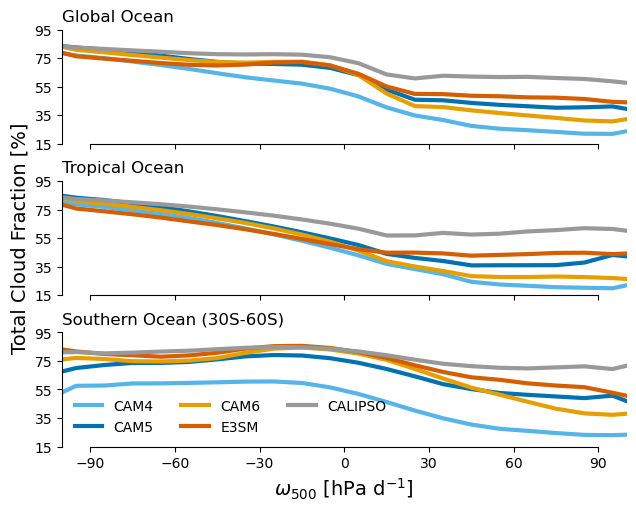

In [17]:
# FIGURE 9
f01, ax01 = plm.plot_lines_by_omega(binned, bin_ctr, colorkey, regions, yvarname='cltcalipso', **{'clip_on':True})
for a in ax01:
    a.set_ylabel("")
    a.set_ylim([15, 95])
    a.set_yticks(np.arange(15, 105, 20))
    a.spines.left.set_bounds((15, 95))
ax01[1].set_ylabel("Total Cloud Fraction [%]")
ax01[2].legend(ncol=3, frameon=False)
ax01[0].get_legend().remove()


regstring = regions['socean'].region_definition()
regstring = f"{regstring}_g{regions['global'].latitudes.stop}"
plotfilename = f"/Users/brianpm/Dropbox/Apps/Overleaf/cam_clouds_generations/Figures/cltcalipso_by_omega500_comparison_{regstring}.pdf"
print(f"OUTPUT: {plotfilename}")
plm.fig_output(f01, plotfilename, clobber_fig=False)

i = 0, r = 'global', b = 'CAM4'
i = 0, r = 'global', b = 'CAM5'
i = 0, r = 'global', b = 'CAM6'
i = 0, r = 'global', b = 'E3SM'
i = 0, r = 'global', b = 'CALIPSO'
i = 0, r = 'global', b = 'CERES'
i = 1, r = 'tropics', b = 'CAM4'
i = 1, r = 'tropics', b = 'CAM5'
i = 1, r = 'tropics', b = 'CAM6'
i = 1, r = 'tropics', b = 'E3SM'
i = 1, r = 'tropics', b = 'CALIPSO'
i = 1, r = 'tropics', b = 'CERES'
i = 2, r = 'socean', b = 'CAM4'
i = 2, r = 'socean', b = 'CAM5'
i = 2, r = 'socean', b = 'CAM6'
i = 2, r = 'socean', b = 'E3SM'
i = 2, r = 'socean', b = 'CALIPSO'
i = 2, r = 'socean', b = 'CERES'
OUTPUT: /Users/brianpm/Dropbox/Apps/Overleaf/cam_clouds_generations/Figures/swcre_by_omega500_comparison_30S-60S_g60.pdf
File already exists ... specify whether to overwrite: False.
Did not save output file.


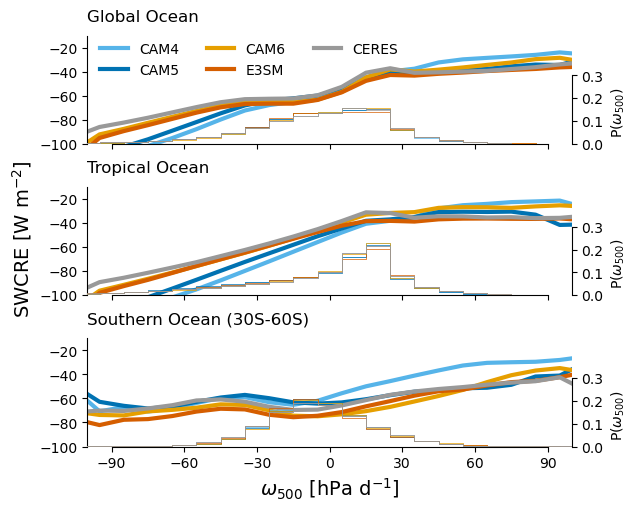

In [20]:
# FIGURE 9
f02, ax02 = plm.plot_lines_by_omega(binned, bin_ctr, colorkey, regions, yvarname='SWCF', **{'clip_on':True})
for a in ax02:
    a.set_ylabel("")
    a.set_ylim([-100, -5])
    a.set_yticks(np.arange(-100, -10, 20))
    a.spines.left.set_bounds((-100, -10))
ax02[1].set_ylabel("SWCRE [W m$^{-2}$]")
ax02[0].get_legend().remove()

atwins = []
atwins = [at.twinx() for at in ax02]  # instantiate a second axes that shares the same x-axis
for i, r in enumerate(regions):
    for j, b in enumerate(binned[r]):
        print(f"{i = }, {r = }, {b = }")
        atwins[i].step(bin_ctr, xhistograms[r][b], color=colorkey[b], linestyle='solid', linewidth=0.5)
[a.set_ylim([0,0.5]) for a in atwins]
[a.set_ylabel("P($\omega_{500}$)", ha='right') for a in atwins]
[a.spines["top"].set_visible(False) for a in atwins]
[a.spines["left"].set_visible(False) for a in atwins]
[a.spines["bottom"].set_visible(False) for a in atwins]
[a.spines.right.set_bounds((0, 0.3)) for a in atwins]
[a.set_yticks(np.arange(0, 0.4, 0.1)) for a in atwins]



[a.set_xlim([-100, 100]) for a in ax02]
[a.set_xticks([-90, -60, -30, 0, 30, 60, 90]) for a in ax02]
[a.spines.bottom.set_bounds((-90, 90)) for a in ax02]
ax02[0].legend(ncol=3, frameon=False)

regstring = regions['socean'].region_definition()
regstring = f"{regstring}_g{regions['global'].latitudes.stop}"
plotfilename = f"/Users/brianpm/Dropbox/Apps/Overleaf/cam_clouds_generations/Figures/swcre_by_omega500_comparison_{regstring}.pdf"
print(f"OUTPUT: {plotfilename}")
plm.fig_output(f02, plotfilename, clobber_fig=False)

aa.shape = (5, 3)
Start model plots
ROW = 1, COL = 0
mb.shape = (40, 22)
p.shape = (22, 40)
ROW = 1, COL = 1
mb.shape = (40, 22)
p.shape = (22, 40)
ROW = 1, COL = 2
mb.shape = (40, 22)
p.shape = (22, 40)
ROW = 2, COL = 0
mb.shape = (40, 22)
p.shape = (22, 40)
ROW = 2, COL = 1
mb.shape = (40, 22)
p.shape = (22, 40)
ROW = 2, COL = 2
mb.shape = (40, 22)
p.shape = (22, 40)
ROW = 3, COL = 0
mb.shape = (40, 22)
p.shape = (22, 40)
ROW = 3, COL = 1
mb.shape = (40, 22)
p.shape = (22, 40)
ROW = 3, COL = 2
mb.shape = (40, 22)
p.shape = (22, 40)
ROW = 4, COL = 0
mb.shape = (40, 22)
p.shape = (22, 40)
ROW = 4, COL = 1
mb.shape = (40, 22)
p.shape = (22, 40)
ROW = 4, COL = 2
mb.shape = (40, 22)
p.shape = (22, 40)


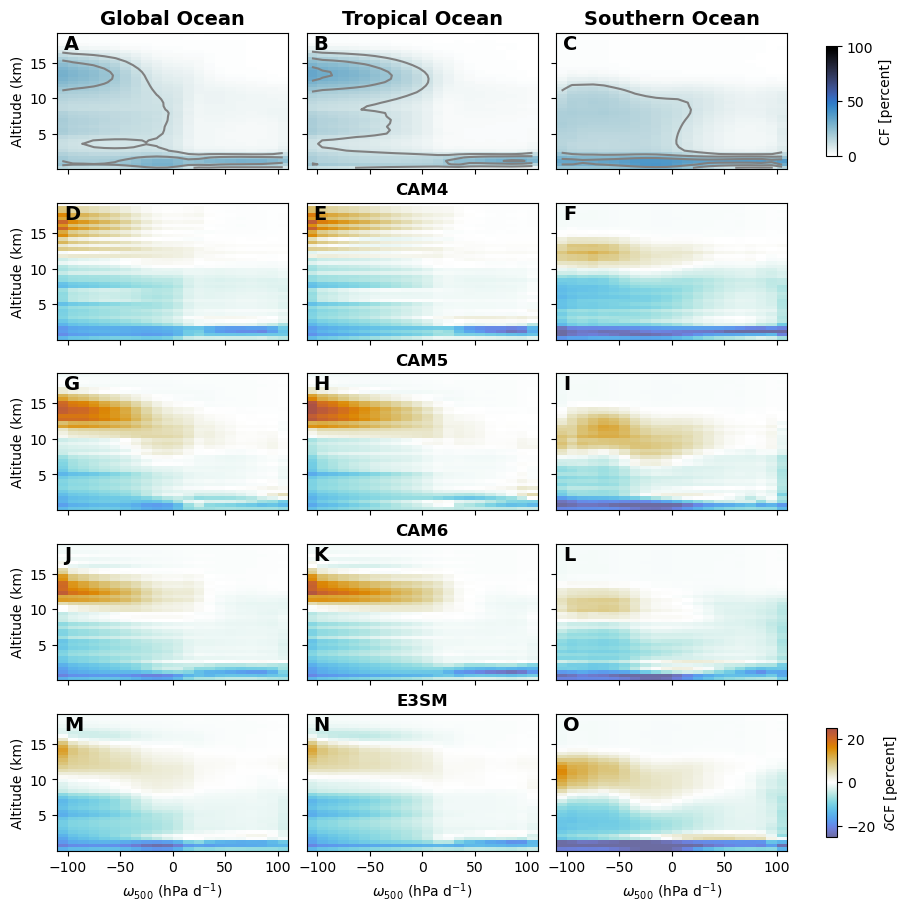

In [81]:
if 'clcalipso' in variables_to_plot:
    ### FIGURE 8
    models = ["CAM4", "CAM5", "CAM6", "E3SM"]

    clrmap = 'cmr.arctic_r'
    fig, aa = plt.subplots(ncols=3, nrows=len(models)+1, figsize=(9,9), constrained_layout=True, sharey=True, sharex=True)
    print(f"{aa.shape = }")
    ax = aa.ravel()
    cnorm = mpl.colors.Normalize(vmin=0., vmax=100)


    v = 'clcalipso' # specified

    mb, mz = np.meshgrid(*[binned['global']['CALIPSO']['clcalipso'].coords[c].values for c in binned['global']['CALIPSO']['clcalipso'].coords])

    ref_case = "CALIPSO"

    CASE = ref_case
    ROW=0
    scal = 1.
    aa[ROW,0].pcolormesh(mb, mz, binned['global'][CASE][v].transpose(), shading='auto', cmap = clrmap, norm=cnorm)
    aa[ROW,0].contour(mb, mz, binned['global'][CASE][v].transpose(), levels=100*np.array([0.1, 0.2, 0.3, 0.4, 0.5]), colors='gray')

    aa[ROW,1].pcolormesh(mb, mz, binned['tropics'][CASE][v].transpose(), shading='auto', cmap = clrmap, norm=cnorm)
    aa[ROW,1].contour(mb, mz, binned['tropics'][CASE][v].transpose(), levels=100*np.array([0.1, 0.2, 0.3, 0.4, 0.5]), colors='gray')

    aa[ROW,2].pcolormesh(mb, mz, binned['socean'][CASE][v].transpose(), shading='auto', cmap = clrmap, norm=cnorm)
    aa[ROW,2].contour(mb, mz, binned['socean'][CASE][v].transpose(), levels=100*np.array([0.1, 0.2, 0.3, 0.4, 0.5]), colors='gray')

    aa[ROW,0].set_ylabel("Altitude (km)")

    rlbl = ["Global Ocean", "Tropical Ocean", "Southern Ocean"]
    [aa[ROW,i].set_title(rlbl[i], fontweight='bold', fontsize=14) for i,r in enumerate(regions)]

    sm = mpl.cm.ScalarMappable(norm=cnorm, cmap=clrmap)
    cbar = fig.colorbar(sm, ax=ax[0:3], orientation='vertical', aspect=10, shrink=0.8, label="CF [percent]")


    clrmap = 'cmr.prinsenvlag_r'
    cnorm = mpl.colors.TwoSlopeNorm(vmin=-25, vcenter=0.0, vmax=25)
    print("Start model plots")
    for ROW, CASE in enumerate(models, start=1):
        for COL, REG in enumerate(regions):
            print(f"{ROW = }, {COL = }")
            # mb, mz = np.meshgrid(*[binned[REG][CASE][v].coords[c].values for c in binned[REG][CASE][v].coords])
            print(f"{mb.shape = }")
            scal = 1.0
            p = binned[REG][CASE][v].values-binned[REG][ref_case][v].values
            print(f"{p.shape = }")
            aa[ROW,COL].pcolormesh(mb, mz, (scal * p).transpose(), shading='auto', cmap = clrmap, norm=cnorm)
        aa[ROW,1].set_title(CASE, fontweight='bold')
        aa[ROW,0].set_ylabel("Altitude (km)")

    [aa[-1,i].set_xlabel("$\omega_{500}$ (hPa d$^{-1}$)") for i,r in enumerate(regions)]

    sm = mpl.cm.ScalarMappable(norm=cnorm, cmap=clrmap)
    cbar = fig.colorbar(sm, ax=aa[-1,:], orientation='vertical', aspect=10, shrink=0.8, label="$\delta$CF [percent]")

    for n, a in enumerate(ax):
        a.text(0.03, 0.88, string.ascii_uppercase[n], transform=a.transAxes, 
                size=14, weight='bold')

    regstring = regions['socean'].region_definition()
    regstring = f"{regstring}_g{regions['global'].latitudes.stop}"
    ofil = Path(f"/Users/brianpm/Dropbox/Apps/Overleaf/cam_clouds_generations/Figures/clcalipso_by_omega500_{regstring}.pdf")
    plm.fig_output(fig, ofil, clobber_fig=False)
else:
    print("clcalipso was not specified to be plotted.")

In [20]:
# This figure is similar to the one in `combined_histogram_error_by_omega_plot.ipynb`
# But this one includes the omega500 histogram with the right-side axis. 
# JS recommended putting the regional bias on ths plot somehow too.
# --> the first way I think of is to include legend in each panel to report the bias.

#  Make this a function? 
# inputs:
# - binned
# - nregions = len(regions)
# - colorkey (parameter set above)
# - regionkey (parameter set above)
# - xvariable (parameter set above)
# - xlabel_string
# - *option* to add PDF of xvarable
#   + xhistograms
# Customized: set_ylabel() * 2, set_xlim, set_ylim() * 2, and spines / yticks
if 'SWCF' in variables_to_load:
    fig, ax = plt.subplots(figsize=(10,9), nrows=len(regions), sharex=True, constrained_layout=True)
    a = ax.ravel()
    atwins = []
    atwins = [at.twinx() for at in a]  # instantiate a second axes that shares the same x-axis
    for i, r in enumerate(regions):
        for j, b in enumerate(binned[r]):
            print(f"{i = }, {r = }, {b = }")
            a[i].plot(bin_ctr, binned[r][b]['SWCF'], label=b, color=colorkey[b], linewidth=3)
            atwins[i].step(bin_ctr, xhistograms[r][b], color=colorkey[b], linestyle='solid', linewidth=0.5)
        a[i].set_title(regionkey[r].title(), loc='left')
    ax[-1].set_xlabel(xlabel_string[xvariable], fontsize=14)
    [a.set_ylabel("SWCRE [W m$^{-2}$]", fontsize=14) for a in ax]
    [a.set_xlim([-100,100]) for a in ax]
    [a.set_ylim([-120,0]) for a in ax]
    [a.set_ylim([0,0.5]) for a in atwins]
    [a.set_ylabel("PDF($\omega_{500}$)", fontsize=14) for a in atwins]
    # rlbl = ["Global Ocean", "Tropical Ocean", "Southern Ocean"]
    # [a[i].set_title(rlbl[i], fontweight='bold', fontsize=14) for i,r in enumerate(regions)]

    [a.spines['right'].set_visible(False) for a in ax]
    [a.spines['top'].set_visible(False) for a in ax]
    [a.spines['top'].set_visible(False) for a in atwins]
    [a.set_yticks([0.0, 0.1, 0.2, 0.3]) for a in atwins]


    [a.spines['right'].set_bounds(low=0, high=0.3) for a in atwins]

    [a.spines['bottom'].set_bounds(low=-90, high=90) for a in ax]
    [a.spines['bottom'].set_bounds(low=-90, high=90) for a in atwins]
    [a.set_xticks(np.arange(-90, 90+20, 20)) for a in ax];
    a[0].legend();

    ofil = Path(f"/Users/brianpm/Dropbox/Apps/Overleaf/cam_clouds_generations/Figures/cam456e3sm_swcf_by_{xvariable}_{rmlandstr}.pdf")
    # NOTE: clobber_fig is defined up in the paramters section!
    plm.fig_output(fig, ofil, clobber_fig=False)
else:
    print("SWCF not specified")

SWCF not specified


CAM4
CAM5
CAM6
OBS
CAM4
CAM5
CAM6
OBS
CAM4
CAM5
CAM6
OBS


[Text(0, 0.5, 'PDF(OMEGA500)'),
 Text(0, 0.5, 'PDF(OMEGA500)'),
 Text(0, 0.5, 'PDF(OMEGA500)')]

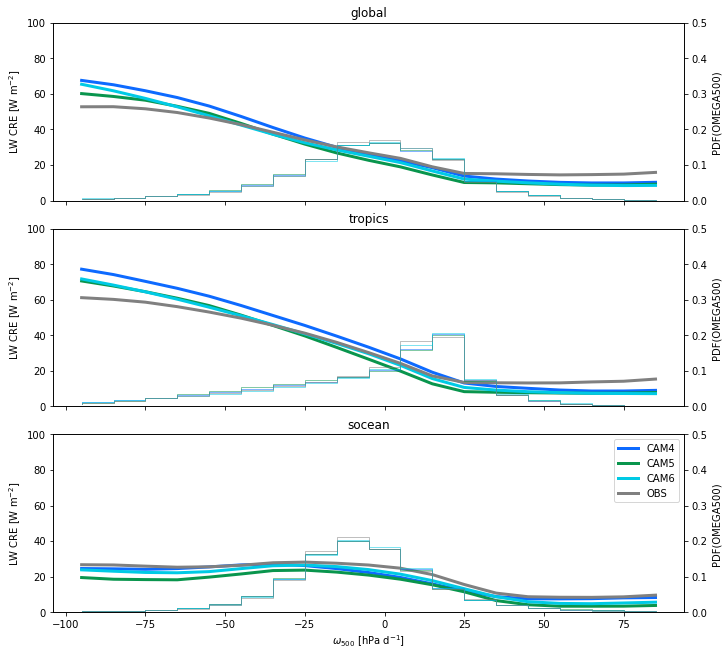

In [13]:
lwcre_binned = dict()

for region in regions:
    lwcre_binned[region] = dict()
    for name in cat:
        y = cat[name]['LWCF'].sel(lat=regions[region])
        x = cat[name][xvariable].sel(lat=regions[region]) 
        if name not in xhistograms[region]:
            xhistograms[region][name], _ = np.histogram(x.values.flatten(), bins=xbins[xvariable], density=True)
            xhistograms[region][name] = xhistograms[region][name] * np.diff(_)  # converts to probability mass function (sum = 1.0)
        # y_bs, edg, num = ss.binned_statistic(x, y, statistic=np.nanmean, bins=xbins[xvariable])
        y_bs, edg, num = comp.weighted_binned(x, y, bins=xbins[xvariable])
        lwcre_binned[region][name] = y_bs

fig, ax = plt.subplots(figsize=(10,9), nrows=len(regions), sharex=True, constrained_layout=True)
a = ax.ravel()
atwins = []
atwins = [at.twinx() for at in a]  # instantiate a second axes that shares the same x-axis
for i, r in enumerate(regions):
    for j, b in enumerate(lwcre_binned[r]):
        print(b)
        a[i].plot(bctr, lwcre_binned[r][b], label=b, color=colorkey[b], linewidth=3)
        atwins[i].step(bctr, xhistograms[r][b], color=colorkey[b], linestyle='solid', linewidth=0.5)
    a[i].set_title(r)
ax[-1].legend()
ax[-1].set_xlabel(xlabel_string[xvariable])
[a.set_ylabel("LW CRE [W m$^{-2}$]") for a in ax]
[a.set_ylim([0,100]) for a in ax]
[a.set_ylim([0,0.5]) for a in atwins]
[a.set_ylabel(f"PDF({xvariable})") for a in atwins]
ofil = Path(f"/Users/brianpm/Dropbox/Apps/Overleaf/cam_clouds_generations/Figures/cam456_lwcf_by_{xvariable}_{rmlandstr}.png")
fig_output(fig, ofil, clobber_fig)

In [12]:
#
# CALIPSO total cloud cover
#

# Data is in cat already

# cld = {}
# VARIABLE = "CLDTOT_CAL"
# for name, case in zip(names, cases):
#     fils = sorted(list(loc2[name].glob(f'{case}.cam.h0.{VARIABLE}.*.nc')))
#     if not fils:
#         print(f"No files: {name}, {case}")
#     else:
#         print(fils)
#     cld[name] = xr.open_mfdataset(fils)[VARIABLE]
#     # remove land
#     cld[name] = rm_land(cld[name], land)

# # INJECT OBSERVATIONS
# cld["OBS"] = cltcalipso
# cat["OBS"] = ew5_calgrid.to_dataset() # already put it there
    
cld_binned = dict()

for region in regions:
    cld_binned[region] = dict()
    for name in cat:
        y = cat[name]['CLDTOT_CAL'].sel(lat=regions[region])
        x = cat[name][xvariable].sel(lat=regions[region]) 
        if name not in xhistograms[region]:
            xhistograms[region][name], _ = np.histogram(x.values.flatten(), bins=xbins[xvariable], density=True)
            xhistograms[region][name] = xhistograms[region][name] * np.diff(_)  # converts to probability mass function (sum = 1.0)
        y_bs, edg, num = ss.binned_statistic(x.values.flatten(), y.values.flatten(), statistic=np.nanmean, bins=xbins[xvariable])
        cld_binned[region][name] = y_bs

CAM4
CAM5
CAM6
OBS
CAM4
CAM5
CAM6
OBS
CAM4
CAM5
CAM6
OBS


[Text(0, 0.5, 'PDF(OMEGA500)'),
 Text(0, 0.5, 'PDF(OMEGA500)'),
 Text(0, 0.5, 'PDF(OMEGA500)')]

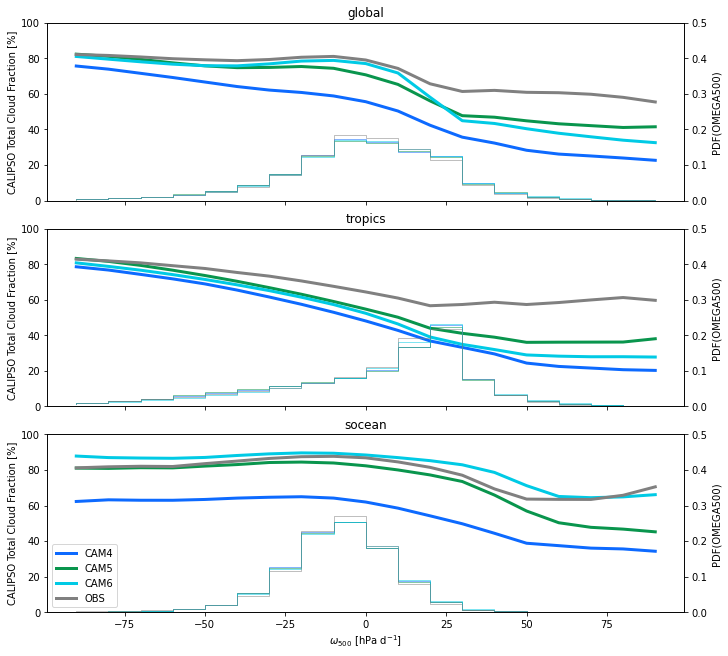

In [13]:
fig, ax = plt.subplots(figsize=(10,9), nrows=len(regions), sharex=True, constrained_layout=True)
a = ax.ravel()
atwins = []
atwins = [at.twinx() for at in a]  # instantiate a second axes that shares the same x-axis
for i, r in enumerate(regions):
    for j, b in enumerate(cld_binned[r]):
        print(b)
        a[i].plot(bctr, cld_binned[r][b], label=b, color=colorkey[b], linewidth=3)
        atwins[i].step(bctr, xhistograms[r][b], color=colorkey[b], linestyle='solid', linewidth=0.5)
    a[i].set_title(r)
ax[-1].legend()
ax[-1].set_xlabel(xlabel_string[xvariable])
[a.set_ylabel("CALIPSO Total Cloud Fraction [%]") for a in ax]
[a.set_ylim([0,100]) for a in ax]
[a.set_ylim([0,0.5]) for a in atwins]
[a.set_ylabel(f"PDF({xvariable})") for a in atwins]
ofil = Path(f"/Users/brianpm/Dropbox/Apps/Overleaf/cam_clouds_generations/Figures/cam456_swcf_by_{xvariable}.png")
fig_output(fig, ofil, clobber_fig)

In [14]:
%%time

# initialize an array for the binned clcalipso
clcalipso_binned_shape = (xhistograms['global']['OBS'].shape[0], len(clcalipso.altitude))

clcalipso_binned = dict()
# do binned statistic level by level. 

for region in regions:
    clcalipso_binned[region] = dict()
    x = cat["OBS"][xvariable].sel(lat=regions[region]) # transfers from our CRE "catalog"
    y = cat["OBS"]['clcalipso'].sel(lat=regions[region])
    tmp = np.zeros(clcalipso_binned_shape)
    for k in range(len(clcalipso.altitude)):
        y_bs, edg, num = ss.binned_statistic(x.values.flatten(), y.isel(altitude=k).values.flatten(), statistic=np.nanmean, bins=xbins[xvariable])
        tmp[:,k] = y_bs
    tmp = xr.DataArray(tmp, dims=["bins","altitude"], coords={"bins":bctr, "altitude":clcalipso['altitude']})
    clcalipso_binned[region]["OBS"] = tmp

CPU times: user 1min 31s, sys: 3.43 s, total: 1min 34s
Wall time: 1min 34s


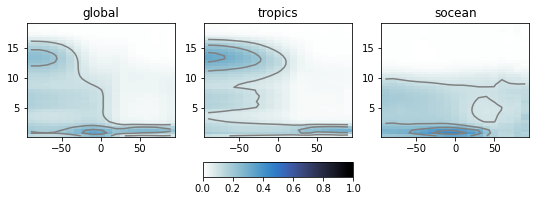

In [15]:
clrmap = 'cmr.arctic_r'
fig, ax = plt.subplots(ncols=3, figsize=(9,3))
cnorm = mpl.colors.Normalize(vmin=0., vmax=1)
mb, mz = np.meshgrid(bctr, clcalipso['altitude'])
ax[0].pcolormesh(mb, mz, clcalipso_binned['global']['OBS'].transpose(), shading='auto', cmap = clrmap, norm=cnorm)
ax[0].contour(mb, mz, clcalipso_binned['global']['OBS'].transpose(), levels=[0.1, 0.2, 0.3, 0.4, 0.5], colors='gray')

ax[1].pcolormesh(mb, mz, clcalipso_binned['tropics']['OBS'].transpose(), shading='auto', cmap = clrmap, norm=cnorm)
ax[1].contour(mb, mz, clcalipso_binned['tropics']['OBS'].transpose(), levels=[0.1, 0.2, 0.3, 0.4, 0.5], colors='gray')

ax[2].pcolormesh(mb, mz, clcalipso_binned['socean']['OBS'].transpose(), shading='auto', cmap = clrmap, norm=cnorm)
ax[2].contour(mb, mz, clcalipso_binned['socean']['OBS'].transpose(), levels=[0.1, 0.2, 0.3, 0.4, 0.5], colors='gray')


[ax[i].set_title(r) for i,r in enumerate(regions)]
sm = mpl.cm.ScalarMappable(norm=cnorm, cmap=clrmap)
cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', aspect=10, shrink=0.3)

In [16]:
%%time
# do binned statistic level by level. 

# initialize an array for the binned clcalipso
clcalipso_binned_shape = (xhistograms['global']['OBS'].shape[0], len(clcalipso.altitude))

clcalipso_binned = dict()
# do binned statistic level by level. 

for mdl in cat:
    print(mdl)
    for region in regions:
        if region not in clcalipso_binned:
            clcalipso_binned[region] = dict()
        x = cat[mdl][xvariable].sel(lat=regions[region]) # transfers from our CRE "catalog"
        y = cat[mdl]['clcalipso'].sel(lat=regions[region])
        if 'cosp_ht' in y.dims:
            y = y.rename({'cosp_ht':'altitude'})
        tmp = np.zeros(clcalipso_binned_shape)
        for k in range(len(clcalipso.altitude)):
            y_bs, edg, num = ss.binned_statistic(x.values.flatten(), y.isel(altitude=k).values.flatten(), statistic=np.nanmean, bins=xbins[xvariable])
            tmp[:,k] = y_bs
        tmp = xr.DataArray(tmp, dims=["bins","altitude"], coords={"bins":bctr, "altitude":clcalipso['altitude']})
        clcalipso_binned[region][mdl] = tmp

CAM4
CAM5
CAM6
OBS
CPU times: user 21min 23s, sys: 58 s, total: 22min 21s
Wall time: 22min 26s


Text(0.5, 0.98, 'OBS')

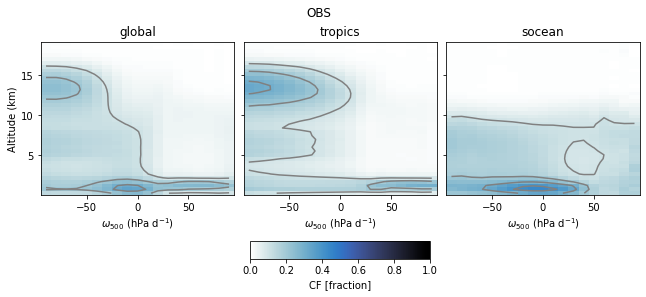

In [17]:
clrmap = 'cmr.arctic_r'
fig, ax = plt.subplots(ncols=3, figsize=(9,4), constrained_layout=True, sharey=True)
cnorm = mpl.colors.Normalize(vmin=0., vmax=1)
mb, mz = np.meshgrid(bctr, clcalipso['altitude'])

CASE = "OBS"
scal = 1.
ax[0].pcolormesh(mb, mz, scal * clcalipso_binned['global'][CASE].transpose(), shading='auto', cmap = clrmap, norm=cnorm)
ax[0].contour(mb, mz, scal * clcalipso_binned['global'][CASE].transpose(), levels=[0.1, 0.2, 0.3, 0.4, 0.5], colors='gray')

ax[1].pcolormesh(mb, mz, scal * clcalipso_binned['tropics'][CASE].transpose(), shading='auto', cmap = clrmap, norm=cnorm)
ax[1].contour(mb, mz, scal * clcalipso_binned['tropics'][CASE].transpose(), levels=[0.1, 0.2, 0.3, 0.4, 0.5], colors='gray')

ax[2].pcolormesh(mb, mz, scal * clcalipso_binned['socean'][CASE].transpose(), shading='auto', cmap = clrmap, norm=cnorm)
ax[2].contour(mb, mz, scal * clcalipso_binned['socean'][CASE].transpose(), levels=[0.1, 0.2, 0.3, 0.4, 0.5], colors='gray')


[ax[i].set_title(r) for i,r in enumerate(regions)]
[ax[i].set_xlabel("$\omega_{500}$ (hPa d$^{-1}$)") for i,r in enumerate(regions)]
ax[0].set_ylabel("Altitude (km)")

sm = mpl.cm.ScalarMappable(norm=cnorm, cmap=clrmap)
cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', aspect=10, shrink=0.3, label="CF [fraction]")
fig.suptitle(CASE)
ofil = Path(f"/Users/brianpm/Dropbox/Apps/Overleaf/cam_clouds_generations/Figures/{CASE}_clcalipso_by_omega500.pdf")
fig_output(fig, ofil, clobber_fig)

Text(0.5, 0.98, 'CAM6 - CALIPSO')

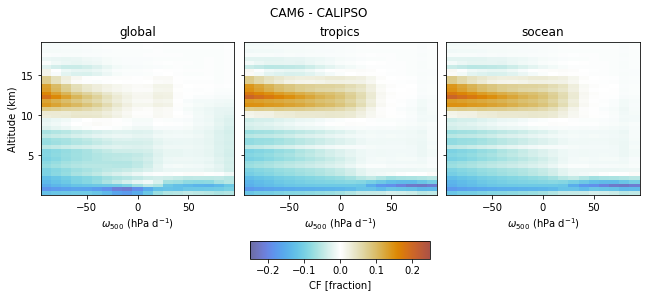

In [18]:
clrmap = 'cmr.prinsenvlag_r'
fig, ax = plt.subplots(ncols=3, figsize=(9,4), constrained_layout=True, sharey=True)
cnorm = mpl.colors.TwoSlopeNorm(vmin=-0.25, vcenter=0.0, vmax=0.25)
mb, mz = np.meshgrid(bctr, clcalipso['altitude'])

CASE = "CAM6"
scal = 0.01
ax[0].pcolormesh(mb, mz, 
                 (scal * clcalipso_binned['global'][CASE]-clcalipso_binned['global']["OBS"]).transpose(),
                 shading='auto', cmap = clrmap, norm=cnorm)
# ax[0].contour(mb, mz, 
#               scal * clcalipso_binned['global'][CASE].transpose(), 
#               levels=[0.1, 0.2, 0.3, 0.4, 0.5], colors='gray')

ax[1].pcolormesh(mb, mz, 
                 (scal * clcalipso_binned['tropics'][CASE]-clcalipso_binned['tropics']["OBS"]).transpose(), 
                 shading='auto', cmap = clrmap, norm=cnorm)
# ax[1].contour(mb, mz, scal * clcalipso_binned['tropics'][CASE].transpose(), levels=[0.1, 0.2, 0.3, 0.4, 0.5], colors='gray')

ax[2].pcolormesh(mb, mz, 
                 (scal * clcalipso_binned['tropics'][CASE]-clcalipso_binned['tropics']["OBS"]).transpose(), 
                 shading='auto', cmap = clrmap, norm=cnorm)
# ax[2].contour(mb, mz, scal * clcalipso_binned['socean'][CASE].transpose(), levels=[0.1, 0.2, 0.3, 0.4, 0.5], colors='gray')


[ax[i].set_title(r) for i,r in enumerate(regions)]
[ax[i].set_xlabel("$\omega_{500}$ (hPa d$^{-1}$)") for i,r in enumerate(regions)]
ax[0].set_ylabel("Altitude (km)")

sm = mpl.cm.ScalarMappable(norm=cnorm, cmap=clrmap)
cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', aspect=10, shrink=0.3, label="CF [fraction]")
fig.suptitle(f"{CASE} - CALIPSO")
ofil = Path(f"/Users/brianpm/Dropbox/Apps/Overleaf/cam_clouds_generations/Figures/{CASE}_error_clcalipso_by_omega500.pdf")
fig_output(fig, ofil, clobber_fig)

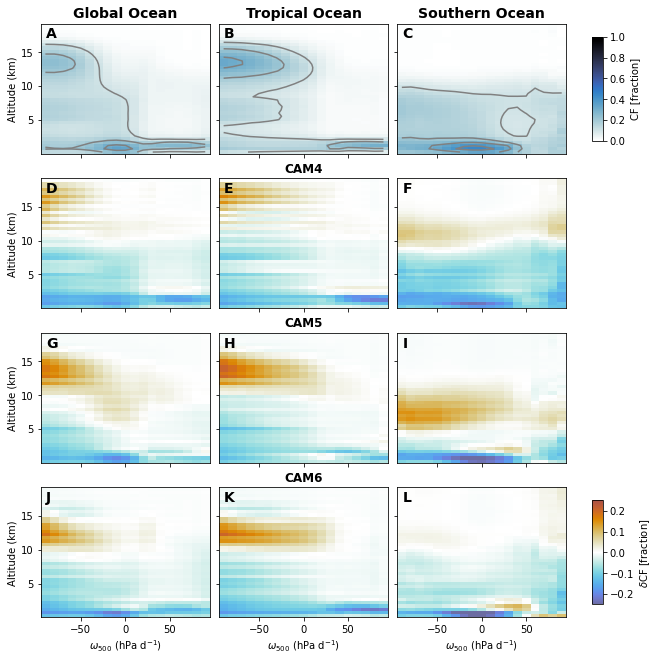

In [19]:
clrmap = 'cmr.arctic_r'
fig, aa = plt.subplots(ncols=3, nrows=4, figsize=(9,9), constrained_layout=True, sharey=True, sharex=True)
ax = aa.ravel()
cnorm = mpl.colors.Normalize(vmin=0., vmax=1)
mb, mz = np.meshgrid(bctr, clcalipso['altitude'])

CASE = "OBS"
ROW=0
scal = 1.
aa[ROW,0].pcolormesh(mb, mz, scal * clcalipso_binned['global'][CASE].transpose(), shading='auto', cmap = clrmap, norm=cnorm)
aa[ROW,0].contour(mb, mz, scal * clcalipso_binned['global'][CASE].transpose(), levels=[0.1, 0.2, 0.3, 0.4, 0.5], colors='gray')

aa[ROW,1].pcolormesh(mb, mz, scal * clcalipso_binned['tropics'][CASE].transpose(), shading='auto', cmap = clrmap, norm=cnorm)
aa[ROW,1].contour(mb, mz, scal * clcalipso_binned['tropics'][CASE].transpose(), levels=[0.1, 0.2, 0.3, 0.4, 0.5], colors='gray')

aa[ROW,2].pcolormesh(mb, mz, scal * clcalipso_binned['socean'][CASE].transpose(), shading='auto', cmap = clrmap, norm=cnorm)
aa[ROW,2].contour(mb, mz, scal * clcalipso_binned['socean'][CASE].transpose(), levels=[0.1, 0.2, 0.3, 0.4, 0.5], colors='gray')

aa[ROW,0].set_ylabel("Altitude (km)")

rlbl = ["Global Ocean", "Tropical Ocean", "Southern Ocean"]
[aa[ROW,i].set_title(rlbl[i], fontweight='bold', fontsize=14) for i,r in enumerate(regions)]

sm = mpl.cm.ScalarMappable(norm=cnorm, cmap=clrmap)
cbar = fig.colorbar(sm, ax=ax[0:3], orientation='vertical', aspect=10, shrink=0.8, label="CF [fraction]")


clrmap = 'cmr.prinsenvlag_r'
cnorm = mpl.colors.TwoSlopeNorm(vmin=-0.25, vcenter=0.0, vmax=0.25)
mb, mz = np.meshgrid(bctr, clcalipso['altitude'])

for ROW, CASE in enumerate(["CAM4", "CAM5", "CAM6"], start=1):
    scal = 0.01
    aa[ROW,0].pcolormesh(mb, mz, 
                     (scal * clcalipso_binned['global'][CASE]-clcalipso_binned['global']["OBS"]).transpose(),
                     shading='auto', cmap = clrmap, norm=cnorm)
    # ax[0].contour(mb, mz, 
    #               scal * clcalipso_binned['global'][CASE].transpose(), 
    #               levels=[0.1, 0.2, 0.3, 0.4, 0.5], colors='gray')

    aa[ROW,1].pcolormesh(mb, mz, 
                     (scal * clcalipso_binned['tropics'][CASE]-clcalipso_binned['tropics']["OBS"]).transpose(), 
                     shading='auto', cmap = clrmap, norm=cnorm)
    # ax[1].contour(mb, mz, scal * clcalipso_binned['tropics'][CASE].transpose(), levels=[0.1, 0.2, 0.3, 0.4, 0.5], colors='gray')

    aa[ROW,2].pcolormesh(mb, mz, 
                     (scal * clcalipso_binned['socean'][CASE]-clcalipso_binned['socean']["OBS"]).transpose(), 
                     shading='auto', cmap = clrmap, norm=cnorm)
    # ax[2].contour(mb, mz, scal * clcalipso_binned['socean'][CASE].transpose(), levels=[0.1, 0.2, 0.3, 0.4, 0.5], colors='gray')
    aa[ROW,1].set_title(CASE, fontweight='bold')
    aa[ROW,0].set_ylabel("Altitude (km)")



[aa[-1,i].set_xlabel("$\omega_{500}$ (hPa d$^{-1}$)") for i,r in enumerate(regions)]

sm = mpl.cm.ScalarMappable(norm=cnorm, cmap=clrmap)
cbar = fig.colorbar(sm, ax=aa[-1,:], orientation='vertical', aspect=10, shrink=0.8, label="$\delta$CF [fraction]")

for n, a in enumerate(ax):
    a.text(0.03, 0.89, string.ascii_uppercase[n], transform=a.transAxes, 
            size=14, weight='bold')
ofil = Path("/Users/brianpm/Dropbox/Apps/Overleaf/cam_clouds_generations/Figures/clcalipso_by_omega500.pdf")
fig_output(fig, ofil, clobber_fig)

In [57]:
# histogram and binned average

tmpbinned = {}
tmpxhistograms = {}
obsname = "OBS"
for region in regions:
    tmpbinned[region] = dict()
    tmpxhistograms[region] = dict()
    x = ew5_calgrid.sel(lat=regions[region])
    tmpxhistograms[region], _ = np.histogram(x.values.flatten(), bins=xbins[xvariable], density=True)
    xhistograms[region][obsname] = tmpxhistograms[region] * np.diff(_)  # converts to probability mass function (sum = 1.0)
    y = cltcalipso.sel(lat=regions[region])
    y_bs, edg, num = ss.binned_statistic(x.values.flatten(), y.values.flatten(), statistic='mean', bins=xbins[xvariable])
    cld_binned[region][obsname] = y_bs


In [24]:
landds = xr.open_dataset("/Users/brianpm/Dropbox/Data/cesm2_f09_land.nc")
landlonmin = landds.lon.min()
print(f"Minimum of lon should be: {landlonmin.item()}")
efils = sorted(Path("/Volumes/Drudonna/E3SM-1-0_amip/remapped").glob("*.nc"))
print(f"{len(efils)} files")
count_wrong = 0
for f in efils:
    tmpds = xr.open_dataset(f)
    assert landds.lat.size == tmpds.lat.size, f"Lat size not the same: {f.name}"
    assert landds.lon.size == tmpds.lon.size, f"Lon size not the same: {f.name}"
    # print(f"Min val of lon is: {tmpds.lon.min().item()}")
    # if not np.all( landds.lon == tmpds.lon):
    #     print(f.name)

    if tmpds.lon.min() != landlonmin:
        count_wrong += 1
    else:
        print(f"_correct_: {f.name}")

print(f"Total: {count_wrong}")

Minimum of lon should be: 0.0
234 files
_correct_: wap_Amon_E3SM-1-0_amip_r1i1p1f1_gr_187001-189412.nc
_correct_: wap_Amon_E3SM-1-0_amip_r1i1p1f1_gr_189501-191912.nc
_correct_: wap_Amon_E3SM-1-0_amip_r1i1p1f1_gr_192001-194412.nc
_correct_: wap_Amon_E3SM-1-0_amip_r1i1p1f1_gr_194501-196912.nc
_correct_: wap_Amon_E3SM-1-0_amip_r1i1p1f1_gr_197001-199412.nc
_correct_: wap_Amon_E3SM-1-0_amip_r1i1p1f1_gr_199501-201412.nc
_correct_: wap_Amon_E3SM-1-0_amip_r2i1p1f1_gr_187001-189412.nc
_correct_: wap_Amon_E3SM-1-0_amip_r2i1p1f1_gr_189501-191912.nc
_correct_: wap_Amon_E3SM-1-0_amip_r2i1p1f1_gr_192001-194412.nc
_correct_: wap_Amon_E3SM-1-0_amip_r2i1p1f1_gr_194501-196912.nc
_correct_: wap_Amon_E3SM-1-0_amip_r2i1p1f1_gr_197001-199412.nc
_correct_: wap_Amon_E3SM-1-0_amip_r2i1p1f1_gr_199501-201412.nc
_correct_: wap_Amon_E3SM-1-0_amip_r3i1p1f1_gr_187001-189412.nc
_correct_: wap_Amon_E3SM-1-0_amip_r3i1p1f1_gr_189501-191912.nc
_correct_: wap_Amon_E3SM-1-0_amip_r3i1p1f1_gr_192001-194412.nc
_correct_: wap_

In [78]:
xhistograms['global']['CAM4']

array([0.00575633, 0.00312371, 0.00462854, 0.00713875, 0.01059049,
       0.01625453, 0.02581837, 0.0431457 , 0.0756122 , 0.12700865,
       0.17074897, 0.16244227, 0.13581673, 0.1233018 , 0.04786796,
       0.02166801, 0.01055797, 0.00491449, 0.00217548, 0.00087626,
       0.00033377, 0.00021901])

'30S-60S'